# HW-3

In [329]:
import hdmpy
import patsy
import warnings
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from statsmodels.api import add_constant
from collections import defaultdict

warnings.simplefilter('ignore')

In [422]:
sample_sizes = [50, 
                150,
                250, 
                350, 
                450, 
                550, 
                650, 
                750]
d = 10 
p = 0.2  
delta = 1 
base =0.3

In [423]:
# A simple experimental data generating process
def gen_data(n, d, p, delta, base):
    D = np.random.binomial(1, p, size=(n,))
    X = np.random.normal(0, 1, size=(n, d))
    y0 = base - X[:, 0] + np.random.normal(0, 1, size=(n,))
    y1 = delta + base - X[:, 0] + np.random.normal(0, 1, size=(n,))
    y = y1 * D + y0 * (1 - D)
    return y, D, X

#### Helper functions for Desparsified Lasso and Double Selection 

In [424]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lasso_model = make_pipeline(StandardScaler(), LassoCV(cv=cv))

def desparsified_lasso(y, D, W):
    f = np.hstack([D.reshape(-1,1), W])
    coefs = lasso_model.fit(f, y)
    scaling_factors = lasso_model[0].scale_  ## get scaling factors for lasso
    true_coefs = coefs[-1].coef_/scaling_factors  ## rescale the parameters
    beta = true_coefs[1:]
    Dres = D - lasso_model.fit(W, D).predict(W)
    a_hat = np.mean((y - W@beta)*Dres)/np.mean(D*Dres)
    epsilon = (y - a_hat*D - W@beta)
    V = np.mean(epsilon**2 * Dres**2)/np.mean(D*Dres)**2
    return a_hat, np.sqrt(V / y.shape[0])


def double_selection(y, D, W):
    X = W
    W = W-W.mean(axis=0)
    W_y_coeffs = lasso_model.fit(W, y)
    W_D_coeffs = lasso_model.fit(W, D)
    
    W_y_ind = W_y_coeffs[-1].coef_.nonzero()   ## indices for controls that are non-zero
    W_D_ind = W_D_coeffs[-1].coef_.nonzero()

    ind = np.unique(np.union1d(W_y_ind, W_D_ind)) ##
                    
    f = np.column_stack((D, X[:,ind]))
                    
    f = f - f.mean(axis=0)
    reg_ols = sm.OLS(y, f).fit(cov_type="HC1")
    return reg_ols.params[0], reg_ols.bse[0]


## Results for Double Selection

Interaction  =  True


,coverage,ATE,std err
50,0.89,0.819496,0.727397
150,0.98,1.000679,0.313889
250,0.96,1.024386,0.233388
350,0.96,0.992420,0.197360
450,1.00,1.012822,0.177416
550,0.96,1.022912,0.157020
650,0.97,1.019157,0.145040
750,0.99,1.001681,0.135498


Interaction  =  False


,coverage,ATE,std err
50,0.96,1.022993,0.512864
150,0.97,0.986573,0.299161
250,0.97,1.017919,0.230679
350,1.00,0.991760,0.192498
450,0.99,1.006755,0.169485
550,0.99,1.012847,0.156375
650,0.96,0.997779,0.142659
750,0.95,0.985302,0.132480


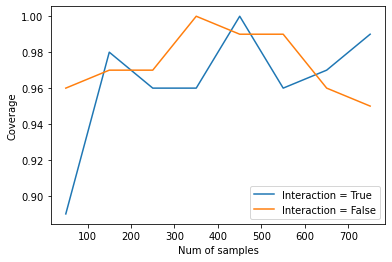

In [426]:
np.random.seed(42)
p = 0.2
def get_coverage_doubleSelection(sample_sizes, d, p, delta, base, trials, interaction):
    params = defaultdict(list)
    coverage = {}
    for sample_size in sample_sizes:
        cov, hats, stderrs = [], [], [],
        for _ in range(trials):
            y, D, X = gen_data(sample_size, d, p, delta, base)
#             X = X-X.mean(axis=0)
            if not interaction: 
                hat, stderr = double_selection(y, D, X)
            else:
                hat, stderr = double_selection(y, D, np.hstack([D.reshape(-1,1)*X, X]))
            hats.append(hat)
            stderrs.append(stderr)
            ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
            cov += [(ci[0] <= delta) & (delta <= ci[1])] 
        coverage[sample_size] = np.mean(cov)
        params[sample_size].append(np.mean(cov))
        params[sample_size].append(np.mean(hats))
        params[sample_size].append(np.mean(stderrs))
    return coverage, params


interactions = [True, False]

for interaction in interactions:
    coverage, params = get_coverage_doubleSelection(p=p, sample_sizes=sample_sizes, d=d, delta=delta, base=base, trials=100, interaction=interaction)
    lists = sorted(coverage.items()) 
    x, y = zip(*lists) 
    plt.plot(x, y, label = f'Interaction = {interaction}')
    plt.xlabel("Num of samples")
    plt.ylabel("Coverage")
    plt.legend()
    print(f'Interaction  =  {interaction}')
    display(pd.DataFrame.from_dict(params, orient='index', columns=["coverage", "ATE", "std err"]))

In [427]:
df = pd.DataFrame.from_dict(params, orient='index', columns=["coverage", "ATE", "std err"])

### Bias (mean absolute error)

In [430]:
np.mean(np.abs(df["ATE"]-delta))

0.012387433013039281

## Results for Desparsified LASSO

Interaction  =  True


,coverage,ATE,std err
50,0.86,0.899823,0.362631
150,0.96,0.968253,0.204395
250,0.92,1.014350,0.156649
350,0.94,1.002617,0.135015
450,0.98,1.005028,0.122780
550,0.98,1.014057,0.108360
650,0.99,1.007614,0.100756
750,0.94,0.988537,0.093928


Interaction  =  False


,coverage,ATE,std err
50,0.94,1.017834,0.337124
150,0.91,0.970864,0.210441
250,0.93,1.018414,0.163603
350,0.97,0.995236,0.137561
450,0.94,1.003683,0.121578
550,0.95,1.007152,0.111367
650,0.96,0.999519,0.101347
750,0.93,0.985745,0.095484


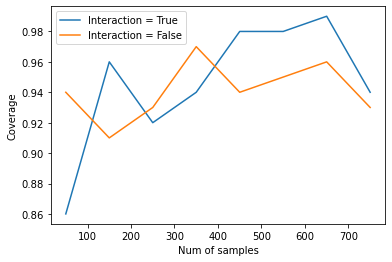

In [431]:
np.random.seed(42)
p = 0.2
def get_coverage_desparsifiedLASSO(sample_sizes, d, p, delta, base, trials, interaction):
    params = defaultdict(list)
    coverage = {}
    for sample_size in sample_sizes:
        cov, hats, stderrs = [], [], [],
        for _ in range(trials):
            y, D, X = gen_data(sample_size, d, p, delta, base)
            X = X-X.mean(axis=0)
            if not interaction: 
                hat, stderr = desparsified_lasso(y, D, X)
            else:
                hat, stderr = desparsified_lasso(y, D, np.hstack([D.reshape(-1,1)*X, X]))
            hats.append(hat)
            stderrs.append(stderr)
            ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
            cov += [(ci[0] <= delta) & (delta <= ci[1])] 
        coverage[sample_size] = np.mean(cov)
        params[sample_size].append(np.mean(cov))
        params[sample_size].append(np.mean(hats))
        params[sample_size].append(np.mean(stderrs))
    return coverage, params


interactions = [True, False]

for interaction in interactions:
    coverage, params = get_coverage_desparsifiedLASSO(p=p, sample_sizes=sample_sizes, d=d, delta=delta, base=base, trials=100, interaction=interaction)
    lists = sorted(coverage.items()) 
    x, y = zip(*lists) 
    plt.plot(x, y, label = f'Interaction = {interaction}')
    plt.xlabel("Num of samples")
    plt.ylabel("Coverage")
    plt.legend()
    print(f'Interaction  =  {interaction}')
    display(pd.DataFrame.from_dict(params, orient='index', columns=["coverage", "ATE", "std err"]))

#### The overall behavior is very similar to the double LASSO with coverage being achieved in relatively few samples ~350.

### Bias (mean absolute error)

In [432]:
df = pd.DataFrame.from_dict(params, orient='index', columns=["coverage", "ATE", "std err"])
np.mean(np.abs(df["ATE"]-delta))

0.011964883545983324